<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Evaluation/CollectedDataset_Evaluation/CollectedDatasetEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model,Model,save_model
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA SET EXPLORATION

In [3]:
datasetpath = '/content/drive/MyDrive/dataset/collected dataset'
lists = os.listdir(datasetpath)
labels = []
file_lst = []
 
for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])

df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])


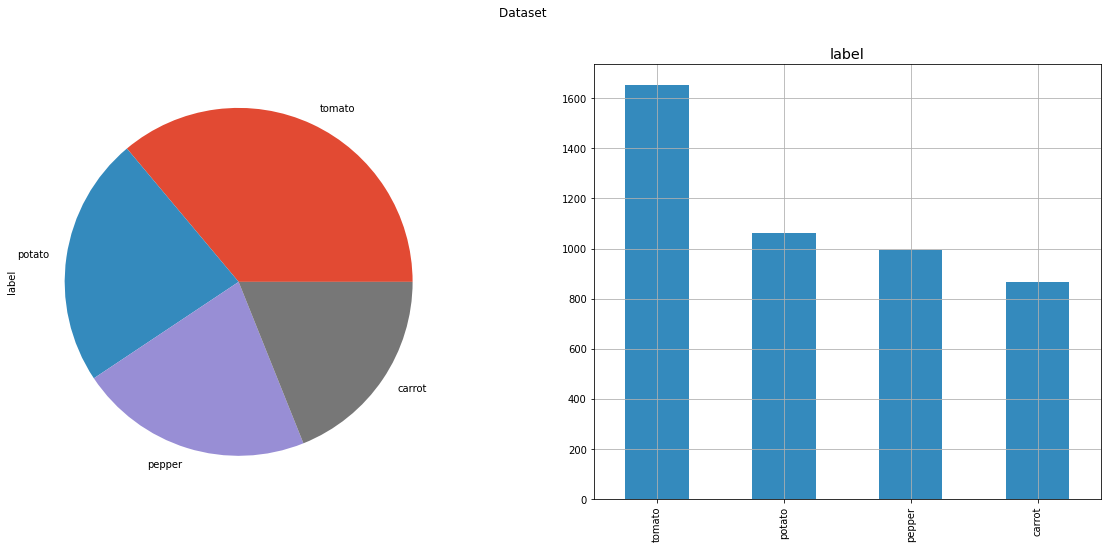

In [4]:

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
with plt.style.context('ggplot'):
  df['label'].value_counts().plot(kind='pie', title='Dataset ',ax = axes[0],subplots=True)
  df['label'].value_counts().plot(kind='bar', color='C1',title='Dataset ',ax = axes[1],subplots=True)
  





# Get The validation set

In [5]:
validationPath= '/content/drive/MyDrive/Plant classification/Results/CollectedDataset/val.csv'
validation_df= pd.read_csv(validationPath)
print(validation_df)

      Unnamed: 0                                       path   label
0           1644                          tomato/15_040.png  tomato
1           1659                          tomato/15_055.png  tomato
2           1510                          tomato/11_042.png  tomato
3           3956                       pepper/Image_491.JPG  pepper
4           2555                       potato/IMG_LB109.jpg  potato
...          ...                                        ...     ...
1368        1461                          tomato/10_036.png  tomato
1369        4431  pepper/images - 2021-08-26T164724.105.jpg  pepper
1370        1176                          tomato/02_064.png  tomato
1371        2803                  potato/IMG_PHL004 (2).jpg  potato
1372        2649                       potato/IMG_LB180.jpg  potato

[1373 rows x 3 columns]


In [6]:
image_size = (224,224)
batch_size = 128
data_set_path = '/content/drive/MyDrive/dataset/collected dataset'
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= data_set_path,
                  target_size=image_size,
                  batch_size=batch_size,
                  shuffle=False
                  ) 

Found 1371 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Load Model

In [7]:
model_path = '/content/drive/MyDrive/Plant classification/Results/CollectedDataset/XceptionArch/XceptionArch.h5'
model = load_model(model_path)

# Evalution per Class

In [8]:
def train_result(history_path):
  train_result_df = pd.read_csv(history_path,index_col=0)
  return train_result_df 

In [9]:
def plot_train_history(train_result_df):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  train_result_df.plot(ax=axes[0],y=['accuracy','val_accuracy'],xlabel='epochs',ylabel='Accuracy')
  train_result_df.plot(ax=axes[1],y=['loss','val_loss'],xlabel='epochs',ylabel='Loss')
 

In [10]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
def crops_evaluate_mdoel(model,validation_generator):
  classes_names =list(validation_generator.class_indices.keys())
  validation_generator.reset()

  start_time = time.time()
  results = model.predict(validation_generator)
  nb_example = np.array(results).shape[1]
  prediction_duration = (time.time() - start_time)/nb_example

  results = np.array(results)
  predicted_labels_idx = np.argmax(results,axis=1)
  predicted_labels_names = np.array([classes_names[label] for label in predicted_labels_idx])

  real_labels_idx = validation_generator.labels
  real_labels_names = np.array([classes_names[label] for label in real_labels_idx])

  report = classification_report(real_labels_names,predicted_labels_names,labels=classes_names,digits=3,output_dict=True)
  
  result_labels = {}
  for label in classes_names:
    crop_result = report[label]
    result_labels[label]=crop_result

  results_df = pd.DataFrame.from_dict(result_labels,orient='index') 
  
  return results_df

# Global Evaluation

In [12]:
def global_evaluate_mdoel(model,validation_generator):

  classes_names =list(validation_generator.class_indices.keys())
  validation_generator.reset()

  start_time = time.time()
  results = model.predict(validation_generator)
  nb_example = np.array(results).shape[1]
  prediction_duration = (time.time() - start_time)/nb_example

  results = np.array(results)
  predicted_labels_idx = np.argmax(results,axis=1)
  predicted_labels_names = np.array([classes_names[label] for label in predicted_labels_idx])

  real_labels_idx = validation_generator.labels
  real_labels_names = np.array([classes_names[label] for label in real_labels_idx])

  report = classification_report(real_labels_names,predicted_labels_names,labels=classes_names,digits=3,output_dict=True)
  model_result = {'prediction_duration':prediction_duration,'Accuracy':report['accuracy'],'Precision':report['macro avg']['precision'],'Recall':report['macro avg']['recall'],'F1-score':report['macro avg']['f1-score']}
  
  return model_result

INFO: Srart test of : MobileNetArch
  -----> training history
        loss  accuracy  val_loss  val_accuracy
0   0.788793  0.688438  0.370611      0.869438
1   0.246180  0.920313  0.274499      0.900802
2   0.107431  0.968125  0.239127      0.916849
3   0.058296  0.985000  0.238435      0.919767
4   0.039285  0.990313  0.250684      0.923414
5   0.028352  0.992500  0.240598      0.921955
6   0.017253  0.996562  0.247634      0.924143
7   0.016244  0.996875  0.245281      0.929249
8   0.018187  0.996250  0.250081      0.926331
9   0.015164  0.995000  0.260909      0.927061
10  0.009640  0.997813  0.253495      0.932896
11  0.009279  0.997500  0.256388      0.927061
12  0.006875  0.998750  0.251224      0.934354
13  0.007164  0.999375  0.254224      0.932896
14  0.008365  0.998125  0.261722      0.929978
  -----> training plots
  -----> print results per crop
        precision    recall  f1-score  support
carrot   0.882759  0.944649  0.912656      271
pepper   0.912281  0.912281  0.91228

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  -----> print results per crop
        precision    recall  f1-score  support
carrot   0.000000  0.000000  0.000000      271
pepper   0.257485  0.150877  0.190265      285
potato   0.218322  0.873288  0.349315      292
tomato   0.305556  0.021033  0.039356      523
  -----> plot results per crop


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


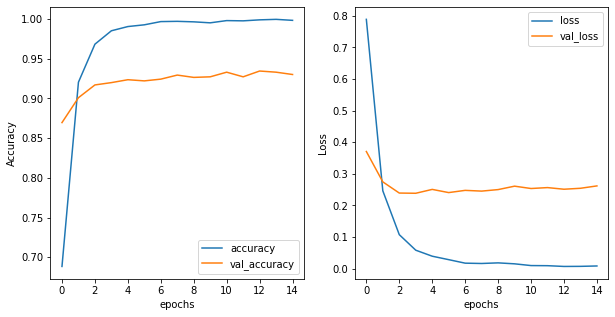

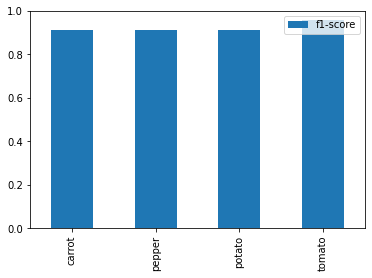

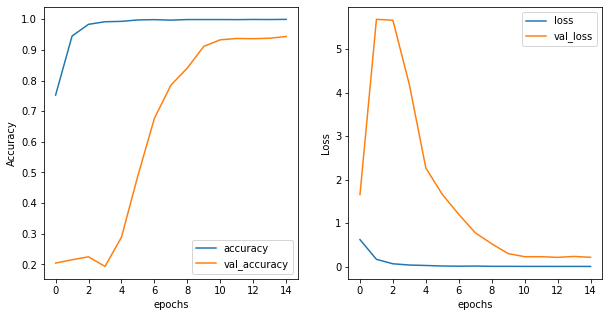

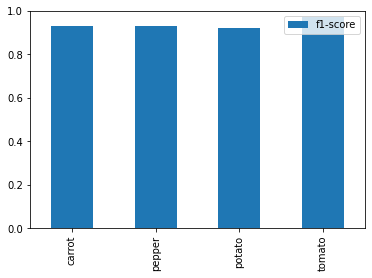

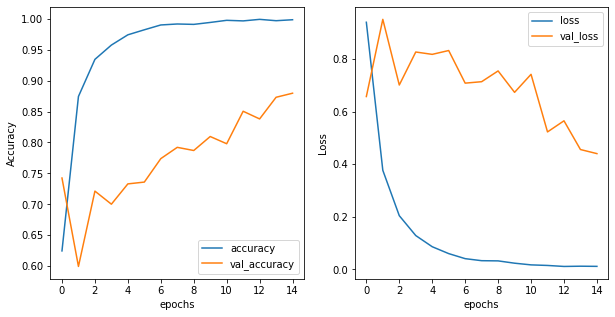

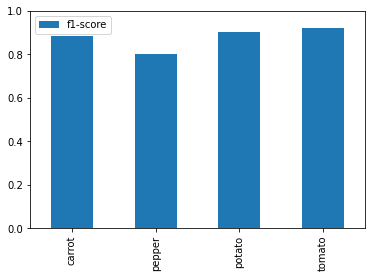

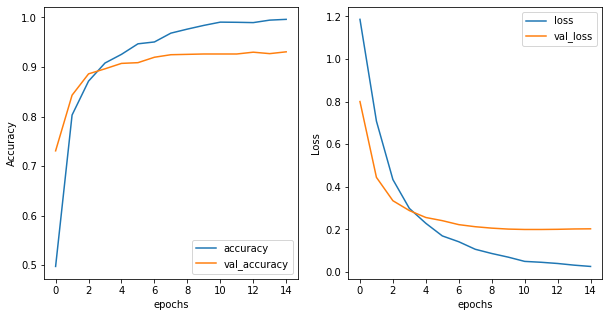

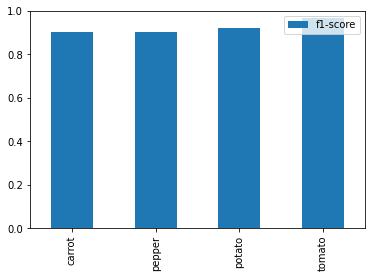

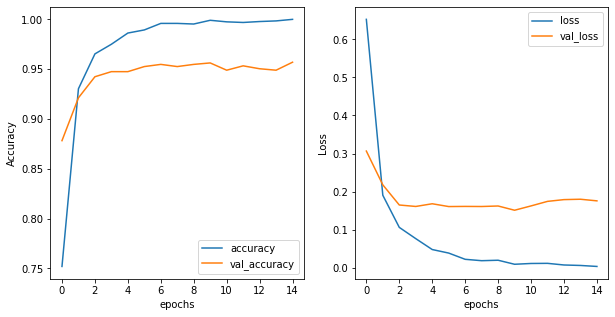

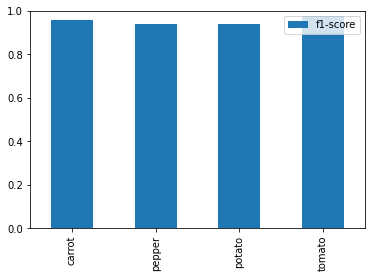

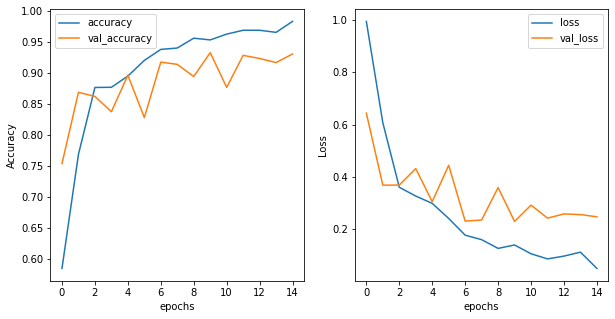

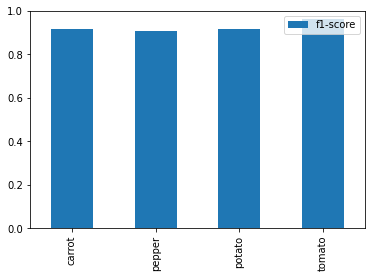

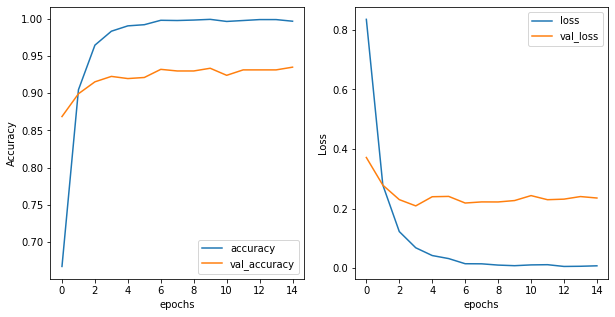

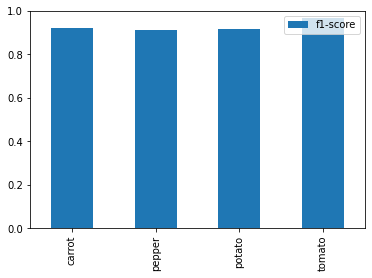

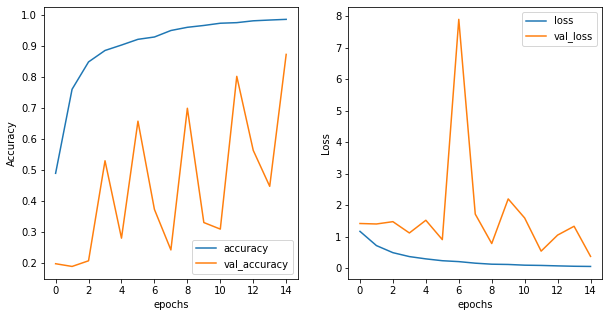

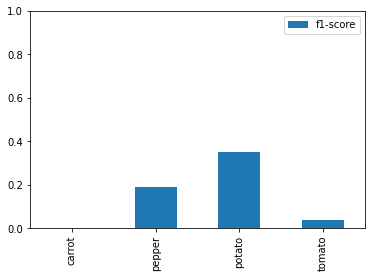

In [13]:
dataset_folder_path ='/content/drive/MyDrive/Plant classification/Results/CollectedDataset'
archs = os.listdir(dataset_folder_path)
archs.remove('train.csv')
archs.remove('val.csv')
archs.remove('NoteBooks')
archs.remove('.ipynb_checkpoints')
archs.remove('SavedFiles')
model_results={}
for arch in archs:
  print('INFO: Srart test of : ' + arch)
  model_path = os.path.join(dataset_folder_path,arch,arch+'.h5')
  model = load_model(model_path)
  
  history_path = os.path.join(dataset_folder_path,arch,'history.csv')
  train_result_df = train_result(history_path)
  print("  -----> training history")
  print(train_result_df)
  print("  -----> training plots")
  plot_train_history(train_result_df)

  plt.savefig('plot.png')

 

  crop_results_df = crops_evaluate_mdoel(model,validation_generator)
  print("  -----> print results per crop")
  print(crop_results_df)
  
  
  print("  -----> plot results per crop")
  crop_results_df.plot(y='f1-score',kind='bar',ylim=(0,1))
  plt.savefig('f1-score.png')
  crop_results_df.to_csv('/content/drive/MyDrive/Plant classification/images/csv files/crop_results_df.csv')

  model_result = global_evaluate_mdoel(model,validation_generator)
  model_results[arch]=model_result

In [16]:
glpbal_resuls_df = pd.DataFrame.from_dict(model_results,orient='index')
print("INFO: print global results")
print(glpbal_resuls_df)
glpbal_resuls_df.to_csv('/content/drive/MyDrive/Plant classification/Results/CollectedDataset/images/csv files/Global_result_df.csv')


INFO: print global results
                  prediction_duration  Accuracy  Precision    Recall  F1-score
MobileNetArch               20.929472  0.929978   0.923708  0.924607  0.923690
ResNet101Arch               22.871640  0.943837   0.937573  0.939004  0.938178
NasNetArch                  21.157788  0.879650   0.890054  0.881120  0.876511
XceptionArch                21.096803  0.930708   0.922058  0.924533  0.923226
 DenseNet121Arch            21.000882  0.956966   0.951369  0.955419  0.953158
VGG19Arch                   20.812556  0.930708   0.923139  0.929128  0.924908
InceptionV3Arch             20.683318  0.935084   0.927781  0.930328  0.928901
EfficientB3Arch             20.997035  0.225383   0.195341  0.261299  0.144734


INFO: plot global results


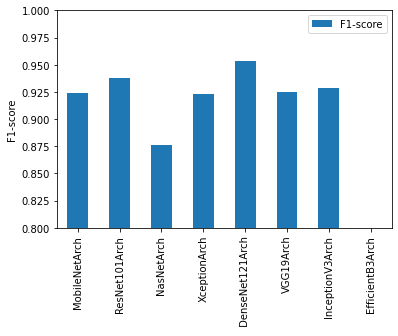

In [17]:
print("INFO: plot global results")
glpbal_resuls_df.plot(y='F1-score',kind='bar',ylim=(0.8,1))

plt.ylabel('F1-score')
plt.savefig('Global result plot .png')

# Confusion Matrix

In [ ]:
model = model = load_model('/content/drive/MyDrive/Plant classification/Results/CollectedDataset/ DenseNet121Arch/ DenseNet121Arch.h5')

In [ ]:
validationPath= '/content/drive/MyDrive/Plant classification/Results/CollectedDataset/val.csv'
validation_df= pd.read_csv(validationPath)
print(validation_df)

      Unnamed: 0                                       path   label
0           1644                          tomato/15_040.png  tomato
1           1659                          tomato/15_055.png  tomato
2           1510                          tomato/11_042.png  tomato
3           3956                       pepper/Image_491.JPG  pepper
4           2555                       potato/IMG_LB109.jpg  potato
...          ...                                        ...     ...
1368        1461                          tomato/10_036.png  tomato
1369        4431  pepper/images - 2021-08-26T164724.105.jpg  pepper
1370        1176                          tomato/02_064.png  tomato
1371        2803                  potato/IMG_PHL004 (2).jpg  potato
1372        2649                       potato/IMG_LB180.jpg  potato

[1373 rows x 3 columns]


In [ ]:
image_size = (224,224)
batch_size = 128
data_set_path = '/content/drive/MyDrive/dataset/collected dataset'
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= data_set_path,
                  target_size=image_size,
                  batch_size=batch_size,
                  shuffle=False
                  ) 

Found 1371 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
Classes_names =list(validation_generator.class_indices.keys())

In [ ]:
validation_generator.reset()
results = model.predict(validation_generator)
results = np.array(results)
predicted_labels_idx = np.argmax(results,axis=1)
predicted_labels_names = np.array([Classes_names[label] for label in predicted_labels_idx])
print(predicted_labels_names.shape)

(1371,)


In [ ]:
real_labels_idx = validation_generator.labels
real_labels_names = np.array([Classes_names[label] for label in real_labels_idx])
print(real_labels_names.shape) 

(1371,)


In [ ]:
conf_matrix = confusion_matrix(real_labels_names,predicted_labels_names,labels=Classes_names,normalize='pred')
conf_matrix_df = pd.DataFrame(conf_matrix, index = Classes_names,columns = Classes_names) 

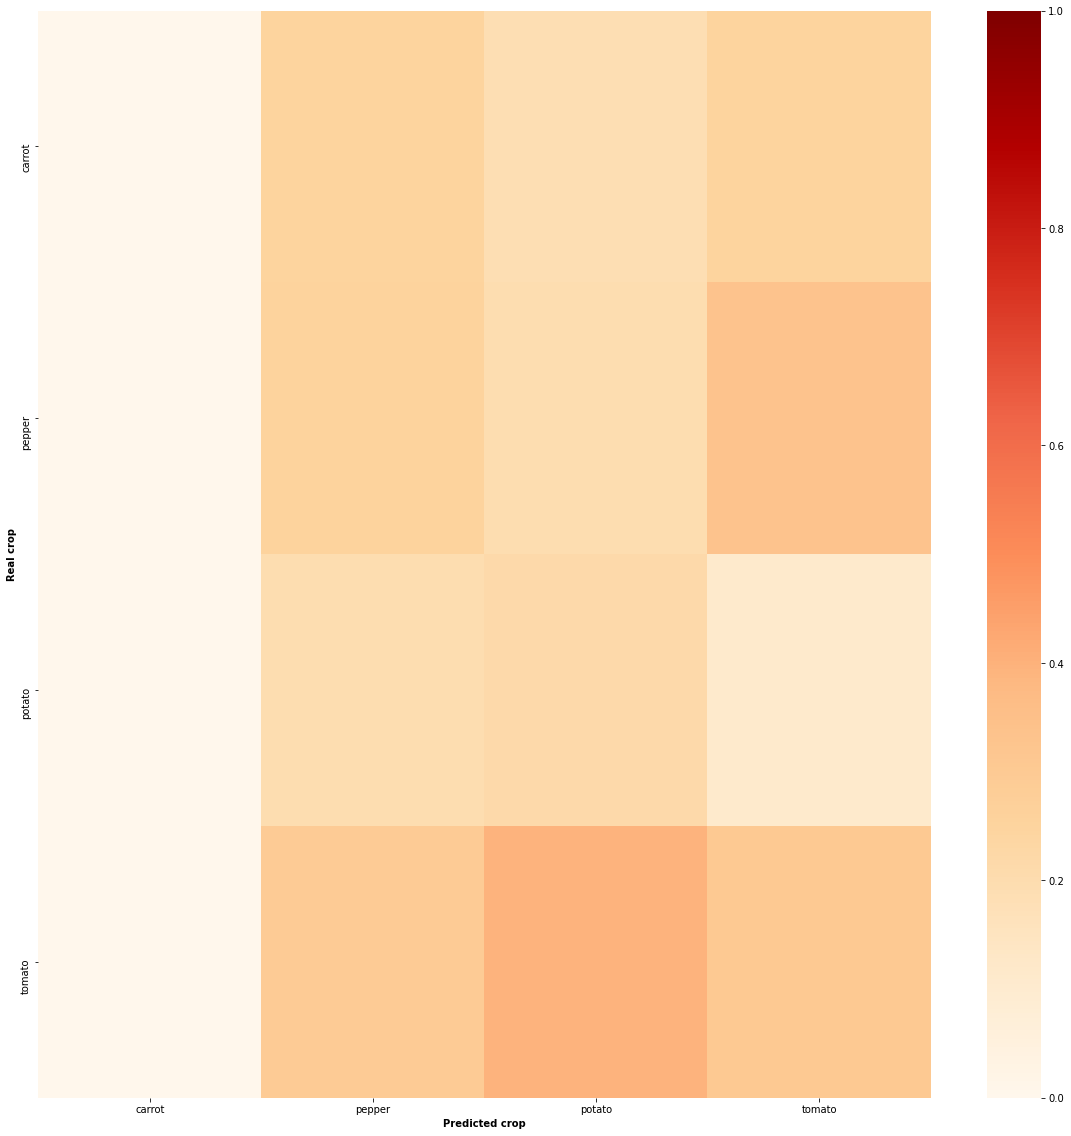

In [ ]:
import seaborn as sn 
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize = (20,20))
heatmap = sn.heatmap(conf_matrix_df, annot=False,fmt='.2f',cmap="OrRd",vmin=0, vmax=1)
heatmap.set_xlabel('Predicted crop',fontsize = 10,fontweight="bold")
heatmap.set_ylabel('Real crop',fontsize = 10,fontweight="bold")
heatmap.figure.savefig("Confusion matrix.png")